In [14]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import mode
import os
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Data Loader and Preprocessor
class DataLoader:
    """Load and preprocess sensor data from multiple recordings"""
    
    def __init__(self, base_path='samples'):
        self.base_path = base_path
        self.activities = ['Standing', 'Walking', 'Jumping', 'Still']
        self.data = {}
        
    def load_all_data(self):
        """Load all activity recordings"""
        print("Loading data from all activities...")
        
        for activity in self.activities:
            activity_data = []
            
            # Look for folders matching the activity pattern
            for i in range(1, 20):  # Check up to 20 recordings
                folder_pattern = f"{activity}{i}"
                folder_path = os.path.join(self.base_path, folder_pattern)
                
                # Also check for zip files
                zip_path = None
                for file in os.listdir(self.base_path):
                    if file.startswith(folder_pattern) and file.endswith('.zip'):
                        zip_path = os.path.join(self.base_path, file)
                        break
                
                if os.path.exists(folder_path):
                    data = self.load_single_recording(folder_path, activity, i)
                    if data is not None:
                        activity_data.append(data)
                elif zip_path:
                    data = self.load_from_zip(zip_path, activity, i)
                    if data is not None:
                        activity_data.append(data)
            
            self.data[activity] = activity_data
            print(f"  {activity}: {len(activity_data)} recordings loaded")
        
        return self.data
    
    def load_from_zip(self, zip_path, activity, index):
        """Extract and load data from zip file"""
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Extract to temporary location
                temp_dir = f"temp_{activity}_{index}"
                zip_ref.extractall(temp_dir)
                
                # Load the data
                data = self.load_single_recording(temp_dir, activity, index)
                
                # Clean up temp directory
                import shutil
                shutil.rmtree(temp_dir)
                
                return data
        except Exception as e:
            print(f"    Error loading {zip_path}: {e}")
            return None
    
    def load_single_recording(self, folder_path, activity, index):
        """Load accelerometer and gyroscope data from a single recording"""
        try:
            accel_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')
            
            if not os.path.exists(accel_path) or not os.path.exists(gyro_path):
                return None
            
            # Load data
            accel = pd.read_csv(accel_path)
            gyro = pd.read_csv(gyro_path)
            
            # Ensure we have the required columns
            required_accel_cols = ['time', 'seconds_elapsed', 'z', 'y', 'x']
            required_gyro_cols = ['time', 'seconds_elapsed', 'z', 'y', 'x']
            
            if not all(col in accel.columns for col in required_accel_cols):
                return None
            if not all(col in gyro.columns for col in required_gyro_cols):
                return None
            
            # Merge on time
            merged = pd.merge_asof(
                accel.sort_values('seconds_elapsed'),
                gyro.sort_values('seconds_elapsed'),
                on='seconds_elapsed',
                suffixes=('_accel', '_gyro'),
                direction='nearest',
                tolerance=0.1
            )
            
            # Create clean dataframe
            data = pd.DataFrame({
                'time': merged['seconds_elapsed'],
                'accel_x': merged['x_accel'],
                'accel_y': merged['y_accel'],
                'accel_z': merged['z_accel'],
                'gyro_x': merged['x_gyro'],
                'gyro_y': merged['y_gyro'],
                'gyro_z': merged['z_gyro'],
                'activity': activity,
                'recording_id': f"{activity}_{index}"
            })
            
            return data
            
        except Exception as e:
            print(f"    Error loading {folder_path}: {e}")
            return None
    
    def visualize_sample_data(self, n_samples=2):
        """Visualize sample recordings from each activity"""
        fig, axes = plt.subplots(4, 2, figsize=(15, 12))
        fig.suptitle('Sample Sensor Data by Activity', fontsize=16, fontweight='bold')
        
        for idx, activity in enumerate(self.activities):
            if len(self.data[activity]) == 0:
                continue
            
            # Take first recording
            sample_data = self.data[activity][0]
            
            # Plot accelerometer
            ax1 = axes[idx, 0]
            ax1.plot(sample_data['time'], sample_data['accel_x'], label='X', alpha=0.7)
            ax1.plot(sample_data['time'], sample_data['accel_y'], label='Y', alpha=0.7)
            ax1.plot(sample_data['time'], sample_data['accel_z'], label='Z', alpha=0.7)
            ax1.set_title(f'{activity} - Accelerometer')
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Acceleration (m/s²)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot gyroscope
            ax2 = axes[idx, 1]
            ax2.plot(sample_data['time'], sample_data['gyro_x'], label='X', alpha=0.7)
            ax2.plot(sample_data['time'], sample_data['gyro_y'], label='Y', alpha=0.7)
            ax2.plot(sample_data['time'], sample_data['gyro_z'], label='Z', alpha=0.7)
            ax2.set_title(f'{activity} - Gyroscope')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Angular Velocity (rad/s)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('raw_sensor_data_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nVisualization saved as 'raw_sensor_data_visualization.png'")


In [16]:

# feature extraction

class FeatureExtractor:
    """Extract time-domain and frequency-domain features"""
    
    def __init__(self, window_size=50):
        self.window_size = window_size
        
    def extract_time_features(self, data):
        """Extract time-domain features from sensor data"""
        features = {}
        
        # For each sensor axis
        for sensor in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            values = data[sensor].values
            
            # Mean
            features[f'{sensor}_mean'] = np.mean(values)
            
            # Variance
            features[f'{sensor}_var'] = np.var(values)
            
            # Standard deviation
            features[f'{sensor}_std'] = np.std(values)
            
            # Root Mean Square (RMS)
            features[f'{sensor}_rms'] = np.sqrt(np.mean(values**2))
            
            # Min and Max
            features[f'{sensor}_min'] = np.min(values)
            features[f'{sensor}_max'] = np.max(values)
            
            # Range
            features[f'{sensor}_range'] = features[f'{sensor}_max'] - features[f'{sensor}_min']
        
        # Signal Magnitude Area (SMA)
        features['accel_sma'] = (
            np.sum(np.abs(data['accel_x'])) +
            np.sum(np.abs(data['accel_y'])) +
            np.sum(np.abs(data['accel_z']))
        ) / len(data)
        
        features['gyro_sma'] = (
            np.sum(np.abs(data['gyro_x'])) +
            np.sum(np.abs(data['gyro_y'])) +
            np.sum(np.abs(data['gyro_z']))
        ) / len(data)
        
        # Correlation between axes
        features['accel_xy_corr'] = np.corrcoef(data['accel_x'], data['accel_y'])[0, 1]
        features['accel_xz_corr'] = np.corrcoef(data['accel_x'], data['accel_z'])[0, 1]
        features['accel_yz_corr'] = np.corrcoef(data['accel_y'], data['accel_z'])[0, 1]
        
        # Total acceleration magnitude
        features['accel_magnitude_mean'] = np.mean(np.sqrt(
            data['accel_x']**2 + data['accel_y']**2 + data['accel_z']**2
        ))
        
        return features
    
    def extract_frequency_features(self, data, sampling_rate=100):
        """Extract frequency-domain features using FFT"""
        features = {}
        
        for sensor in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            values = data[sensor].values
            
            # Compute FFT
            fft_values = np.abs(fft(values))
            freqs = fftfreq(len(values), 1/sampling_rate)
            
            # Only use positive frequencies
            positive_freqs = freqs[:len(freqs)//2]
            fft_magnitude = fft_values[:len(fft_values)//2]
            
            # Dominant frequency
            if len(fft_magnitude) > 0:
                dominant_idx = np.argmax(fft_magnitude)
                features[f'{sensor}_dominant_freq'] = positive_freqs[dominant_idx]
            else:
                features[f'{sensor}_dominant_freq'] = 0
            
            # Spectral energy
            features[f'{sensor}_spectral_energy'] = np.sum(fft_magnitude**2)
            
            # Spectral entropy
            psd = fft_magnitude**2
            psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
            psd_norm = psd_norm[psd_norm > 0]  # Remove zeros
            features[f'{sensor}_spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm)) if len(psd_norm) > 0 else 0
        
        return features
    
    def extract_all_features(self, data, sampling_rate=100):
        """Extract both time and frequency domain features"""
        time_features = self.extract_time_features(data)
        freq_features = self.extract_frequency_features(data, sampling_rate)
        
        # Combine all features
        all_features = {**time_features, **freq_features}
        
        return all_features
    
    def process_all_recordings(self, data_dict, sampling_rate=100):
        """Process all recordings and extract features"""
        feature_list = []
        labels = []
        recording_ids = []
        
        print("\nExtracting features from all recordings...")
        
        for activity, recordings in data_dict.items():
            print(f"  Processing {activity}: {len(recordings)} recordings")
            
            for recording in recordings:
                if recording is None or len(recording) < self.window_size:
                    continue
                
                # Use sliding windows or whole recording
                features = self.extract_all_features(recording, sampling_rate)
                feature_list.append(features)
                labels.append(activity)
                recording_ids.append(recording['recording_id'].iloc[0])
        
        # Convert to DataFrame
        features_df = pd.DataFrame(feature_list)
        features_df['activity'] = labels
        features_df['recording_id'] = recording_ids
        
        print(f"\nExtracted {len(features_df.columns)-2} features from {len(features_df)} recordings")
        
        return features_df
    
    def normalize_features(self, features_df):
        """Normalize features using Z-score normalization"""
        feature_cols = [col for col in features_df.columns 
                       if col not in ['activity', 'recording_id']]
        
        # Z-score normalization
        normalized_df = features_df.copy()
        normalized_df[feature_cols] = (features_df[feature_cols] - features_df[feature_cols].mean()) / features_df[feature_cols].std()
        
        # Replace NaN with 0 (in case of zero variance)
        normalized_df[feature_cols] = normalized_df[feature_cols].fillna(0)
        
        print("Features normalized using Z-score normalization")
        
        return normalized_df

In [17]:

# hidden markov model implementation

class HiddenMarkovModel:
    """Hidden Markov Model with Viterbi and Baum-Welch algorithms"""
    
    def __init__(self, n_states=4, n_features=10):
        self.n_states = n_states
        self.n_features = n_features
        
        # Initialize parameters
        self.states = None
        self.initial_prob = None
        self.transition_prob = None
        self.emission_means = None
        self.emission_covs = None
        
    def initialize_parameters(self, X, y, state_names):
        """Initialize HMM parameters from data"""
        self.states = state_names
        self.n_states = len(state_names)
        
        # Initial probabilities (uniform)
        self.initial_prob = np.ones(self.n_states) / self.n_states
        
        # Transition probabilities (slightly favor staying in same state)
        self.transition_prob = np.ones((self.n_states, self.n_states)) * 0.1
        np.fill_diagonal(self.transition_prob, 0.7)
        
        # Normalize rows
        self.transition_prob = self.transition_prob / self.transition_prob.sum(axis=1, keepdims=True)
        
        # Emission parameters (Gaussian distributions)
        self.emission_means = np.zeros((self.n_states, X.shape[1]))
        self.emission_covs = np.zeros((self.n_states, X.shape[1], X.shape[1]))
        
        for i, state in enumerate(state_names):
            state_data = X[y == state]
            if len(state_data) > 0:
                self.emission_means[i] = np.mean(state_data, axis=0)
                cov = np.cov(state_data.T)
                # Add small regularization to avoid singular matrices
                self.emission_covs[i] = cov + np.eye(X.shape[1]) * 1e-6
        
        print("HMM parameters initialized")
    
    def _gaussian_prob(self, x, mean, cov):
        """Calculate Gaussian probability"""
        try:
            diff = x - mean
            inv_cov = np.linalg.inv(cov)
            exponent = -0.5 * np.dot(np.dot(diff, inv_cov), diff.T)
            normalizer = 1.0 / np.sqrt((2 * np.pi)**len(mean) * np.linalg.det(cov))
            return normalizer * np.exp(exponent)
        except:
            return 1e-10  # Return small value if calculation fails
    
    def _emission_probability(self, observation, state):
        """Calculate emission probability for an observation given a state"""
        prob = self._gaussian_prob(observation, 
                                   self.emission_means[state], 
                                   self.emission_covs[state])
        return max(prob, 1e-10)  # Avoid zero probabilities
    
    def viterbi(self, observations):
        """
        Viterbi algorithm for finding most likely state sequence
        
        Args:
            observations: Array of shape (n_observations, n_features)
        
        Returns:
            Most likely state sequence
        """
        T = len(observations)
        
        # Initialize
        viterbi_matrix = np.zeros((self.n_states, T))
        backpointer = np.zeros((self.n_states, T), dtype=int)
        
        # Initial step
        for s in range(self.n_states):
            viterbi_matrix[s, 0] = (np.log(self.initial_prob[s] + 1e-10) + 
                                   np.log(self._emission_probability(observations[0], s)))
        
        # Forward pass
        for t in range(1, T):
            for s in range(self.n_states):
                # Calculate probabilities from all previous states
                trans_probs = viterbi_matrix[:, t-1] + np.log(self.transition_prob[:, s] + 1e-10)
                backpointer[s, t] = np.argmax(trans_probs)
                viterbi_matrix[s, t] = (np.max(trans_probs) + 
                                       np.log(self._emission_probability(observations[t], s)))
        
        # Backtrack to find best path
        best_path = np.zeros(T, dtype=int)
        best_path[-1] = np.argmax(viterbi_matrix[:, -1])
        
        for t in range(T-2, -1, -1):
            best_path[t] = backpointer[best_path[t+1], t+1]
        
        return best_path
    
    def baum_welch(self, observations_list, max_iterations=100, convergence_threshold=1e-4):
        """
        Baum-Welch algorithm for training HMM parameters
        
        Args:
            observations_list: List of observation sequences
            max_iterations: Maximum number of iterations
            convergence_threshold: Threshold for convergence
        """
        print("\nTraining HMM using Baum-Welch algorithm...")
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(max_iterations):
            # E-step: Calculate forward and backward probabilities
            total_log_likelihood = 0
            
            new_initial_prob = np.zeros(self.n_states)
            new_transition_prob = np.zeros((self.n_states, self.n_states))
            new_emission_means = np.zeros((self.n_states, self.n_features))
            new_emission_covs = np.zeros((self.n_states, self.n_features, self.n_features))
            
            state_counts = np.zeros(self.n_states)
            
            for observations in observations_list:
                T = len(observations)
                
                # Forward algorithm
                alpha = np.zeros((self.n_states, T))
                for s in range(self.n_states):
                    alpha[s, 0] = (self.initial_prob[s] * 
                                  self._emission_probability(observations[0], s))
                
                for t in range(1, T):
                    for s in range(self.n_states):
                        alpha[s, t] = (np.sum(alpha[:, t-1] * self.transition_prob[:, s]) *
                                      self._emission_probability(observations[t], s))
                
                # Backward algorithm
                beta = np.zeros((self.n_states, T))
                beta[:, -1] = 1
                
                for t in range(T-2, -1, -1):
                    for s in range(self.n_states):
                        beta[s, t] = np.sum(
                            self.transition_prob[s, :] *
                            np.array([self._emission_probability(observations[t+1], s2) 
                                     for s2 in range(self.n_states)]) *
                            beta[:, t+1]
                        )
                
                # Calculate gamma and xi
                gamma = alpha * beta
                gamma = gamma / (np.sum(gamma, axis=0) + 1e-10)
                
                total_log_likelihood += np.log(np.sum(alpha[:, -1]) + 1e-10)
                
                # Accumulate statistics
                new_initial_prob += gamma[:, 0]
                
                for t in range(T-1):
                    xi = np.zeros((self.n_states, self.n_states))
                    for i in range(self.n_states):
                        for j in range(self.n_states):
                            xi[i, j] = (alpha[i, t] * self.transition_prob[i, j] *
                                       self._emission_probability(observations[t+1], j) *
                                       beta[j, t+1])
                    xi = xi / (np.sum(xi) + 1e-10)
                    new_transition_prob += xi
                
                for s in range(self.n_states):
                    state_counts[s] += np.sum(gamma[s, :])
                    for t in range(T):
                        new_emission_means[s] += gamma[s, t] * observations[t]
            
            # M-step: Update parameters
            self.initial_prob = new_initial_prob / (np.sum(new_initial_prob) + 1e-10)
            self.transition_prob = new_transition_prob / (np.sum(new_transition_prob, axis=1, keepdims=True) + 1e-10)
            
            for s in range(self.n_states):
                if state_counts[s] > 0:
                    self.emission_means[s] = new_emission_means[s] / state_counts[s]
            
            # Check convergence
            log_likelihood_change = total_log_likelihood - prev_log_likelihood
            
            if iteration % 10 == 0:
                print(f"  Iteration {iteration}: Log-likelihood = {total_log_likelihood:.2f}, Change = {log_likelihood_change:.4f}")
            
            if abs(log_likelihood_change) < convergence_threshold:
                print(f"\nConverged after {iteration+1} iterations")
                break
            
            prev_log_likelihood = total_log_likelihood
        
        else:
            print(f"\nReached maximum iterations ({max_iterations})")
    
    def predict(self, observations):
        """Predict state sequence for observations"""
        state_indices = self.viterbi(observations)
        return [self.states[i] for i in state_indices]
    
    def visualize_transition_matrix(self):
        """Visualize transition probability matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.transition_prob, annot=True, fmt='.3f', 
                   xticklabels=self.states, yticklabels=self.states,
                   cmap='YlOrRd', cbar_kws={'label': 'Probability'})
        plt.title('State Transition Probability Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.tight_layout()
        plt.savefig('transition_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Transition matrix saved as 'transition_matrix.png'")
    
    def visualize_emission_probabilities(self, feature_names, top_n=10):
        """Visualize emission probability parameters (means)"""
        # Select top N most important features
        feature_importance = np.abs(self.emission_means).mean(axis=0)
        top_indices = np.argsort(feature_importance)[-top_n:]
        
        plt.figure(figsize=(12, 6))
        
        x = np.arange(len(top_indices))
        width = 0.2
        
        for i, state in enumerate(self.states):
            plt.bar(x + i*width, self.emission_means[i, top_indices], 
                   width, label=state, alpha=0.8)
        
        plt.xlabel('Features')
        plt.ylabel('Mean Value')
        plt.title(f'Top {top_n} Feature Means by State', fontsize=14, fontweight='bold')
        plt.xticks(x + width*1.5, [feature_names[i] for i in top_indices], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.savefig('emission_probabilities.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Emission probabilities saved as 'emission_probabilities.png'")

In [18]:


# model evaluation

class ModelEvaluator:
    """Evaluate HMM performance"""
    
    def __init__(self, model, state_names):
        self.model = model
        self.state_names = state_names
    
    def evaluate(self, X_test, y_test):
        """Evaluate model on test data"""
        print("\nEvaluating model on test data...")
        
        # Make predictions
        predictions = []
        for observation in X_test:
            pred = self.model.viterbi(observation.reshape(1, -1))
            predictions.append(self.state_names[pred[0]])
        
        predictions = np.array(predictions)
        
        # Calculate metrics for each state
        results = []
        for state in self.state_names:
            tp = np.sum((predictions == state) & (y_test == state))
            fp = np.sum((predictions == state) & (y_test != state))
            tn = np.sum((predictions != state) & (y_test != state))
            fn = np.sum((predictions != state) & (y_test == state))
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            
            results.append({
                'State': state,
                'Samples': np.sum(y_test == state),
                'Sensitivity': f'{sensitivity:.3f}',
                'Specificity': f'{specificity:.3f}',
                'Accuracy': f'{accuracy:.3f}'
            })
        
        # Overall accuracy
        overall_accuracy = np.mean(predictions == y_test)
        
        print(f"\n Overall Accuracy: {overall_accuracy:.3f}")
        
        return pd.DataFrame(results), predictions, overall_accuracy
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        from sklearn.metrics import confusion_matrix
        
        cm = confusion_matrix(y_true, y_pred, labels=self.state_names)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.state_names,
                   yticklabels=self.state_names)
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('True Activity')
        plt.xlabel('Predicted Activity')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Confusion matrix saved as 'confusion_matrix.png'")
    
    def plot_predictions(self, X_test, y_test, predictions, n_samples=4):
        """Visualize predictions vs true labels"""
        fig, axes = plt.subplots(n_samples, 1, figsize=(12, 8))
        
        for i in range(min(n_samples, len(X_test))):
            ax = axes[i] if n_samples > 1 else axes
            
            # Plot feature values
            ax.plot(X_test[i, :10], 'o-', alpha=0.6, label='Features (first 10)')
            
            # Add title with true and predicted labels
            ax.set_title(f'Sample {i+1}: True={y_test[i]}, Predicted={predictions[i]}',
                        fontweight='bold')
            ax.set_xlabel('Feature Index')
            ax.set_ylabel('Normalized Value')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.savefig('prediction_examples.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Prediction examples saved as 'prediction_examples.png'")

HUMAN ACTIVITY RECOGNITION USING HIDDEN MARKOV MODELS

STEP 1: DATA LOADING
Loading data from all activities...
  Standing: 12 recordings loaded
  Walking: 15 recordings loaded
  Jumping: 14 recordings loaded
  Still: 12 recordings loaded


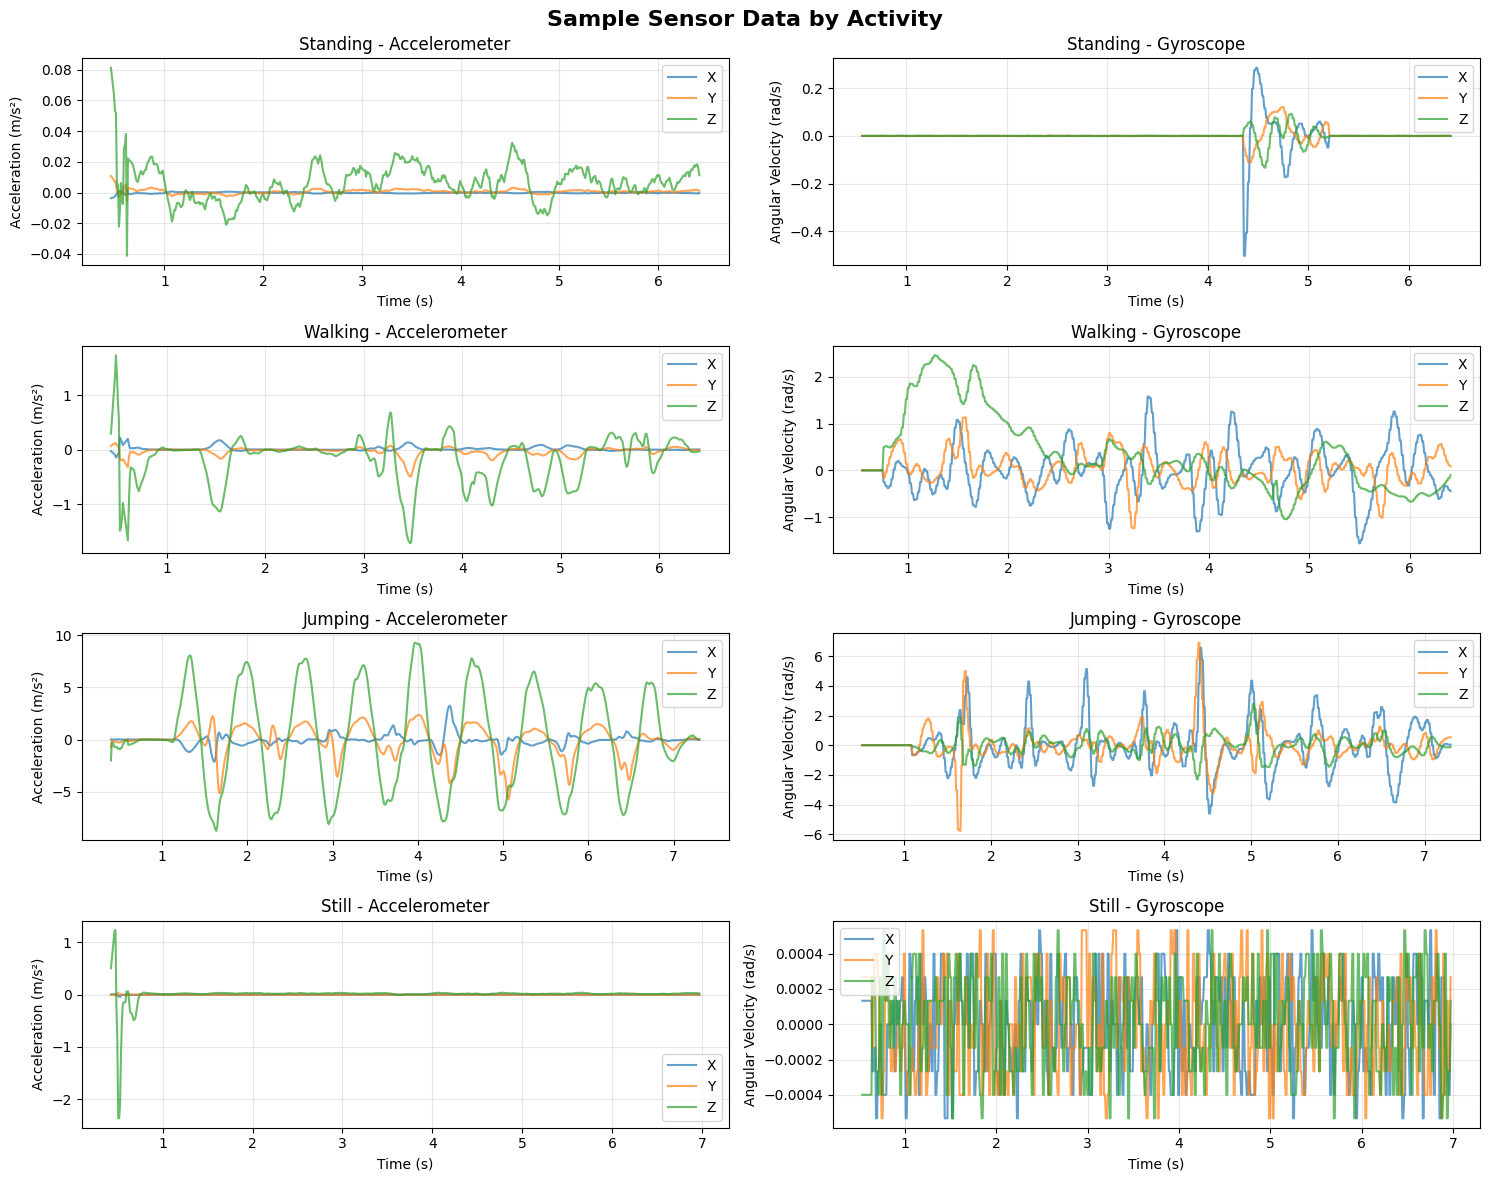


Visualization saved as 'raw_sensor_data_visualization.png'

STEP 2: FEATURE EXTRACTION

Extracting features from all recordings...
  Processing Standing: 12 recordings
  Processing Walking: 15 recordings
  Processing Jumping: 14 recordings
  Processing Still: 12 recordings

Extracted 66 features from 53 recordings
Features normalized using Z-score normalization

Feature Summary:
       accel_x_mean   accel_x_var   accel_x_std   accel_x_rms   accel_x_min  \
count  5.300000e+01  5.300000e+01  5.300000e+01  5.300000e+01  5.300000e+01   
mean  -4.189521e-18 -7.331661e-18  1.466332e-17  7.960090e-17  6.284281e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -5.137347e+00 -4.439788e-01 -6.188363e-01 -6.119331e-01 -4.697264e+00   
25%    2.729594e-01 -4.439787e-01 -6.185709e-01 -6.116508e-01 -2.320985e-01   
50%    2.769321e-01 -4.410976e-01 -5.250004e-01 -5.163539e-01  5.086559e-01   
75%    3.710977e-01  3.747064e-02  5.972768e-01  6.092296e-01  5

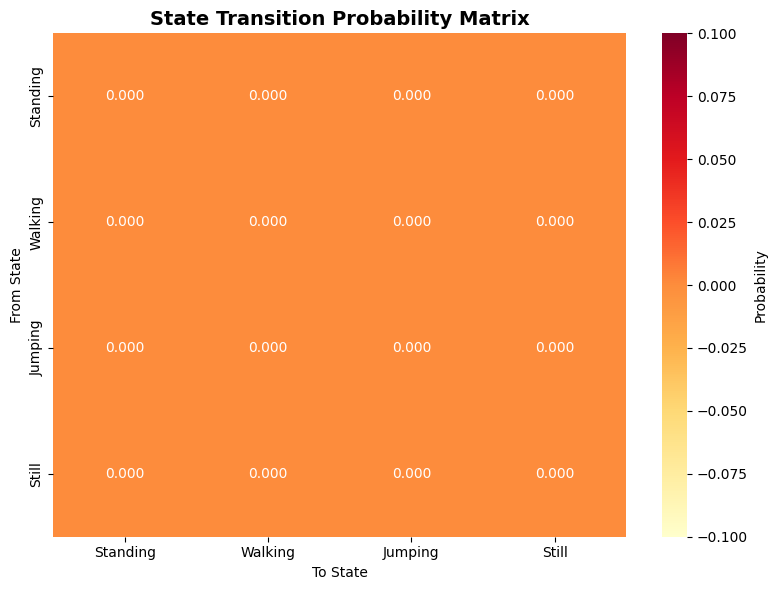

Transition matrix saved as 'transition_matrix.png'


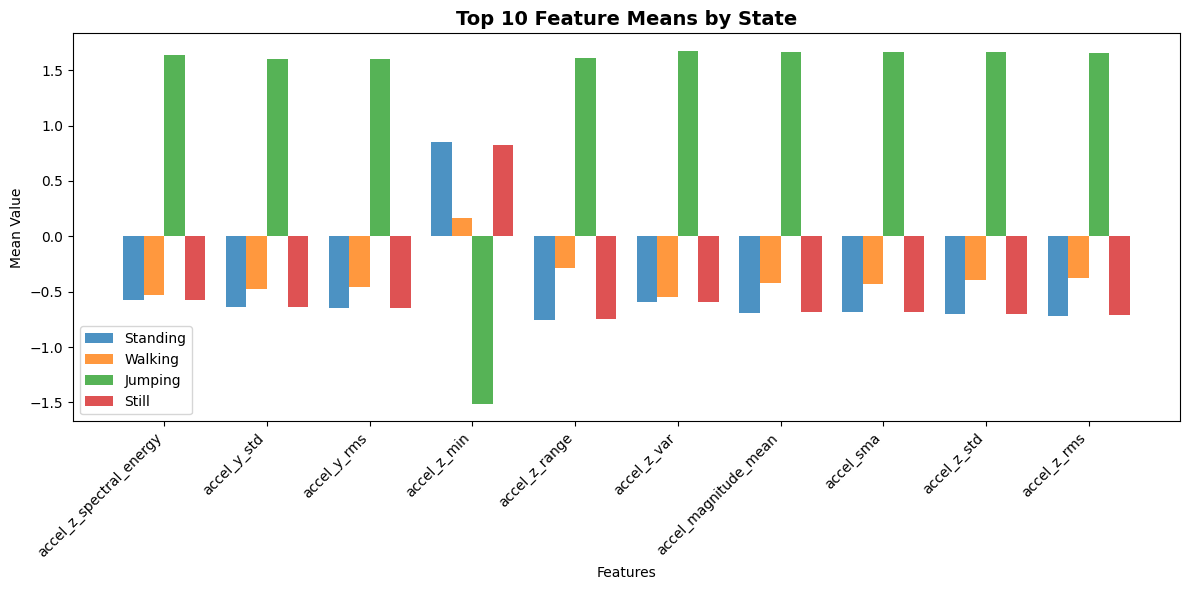

Emission probabilities saved as 'emission_probabilities.png'

STEP 6: MODEL EVALUATION

Evaluating model on test data...

 Overall Accuracy: 0.182

Detailed Results by Activity:
   State  Samples Sensitivity Specificity Accuracy
Standing        2       1.000       0.000    0.182
 Walking        4       0.000       1.000    0.636
 Jumping        2       0.000       1.000    0.818
   Still        3       0.000       1.000    0.727


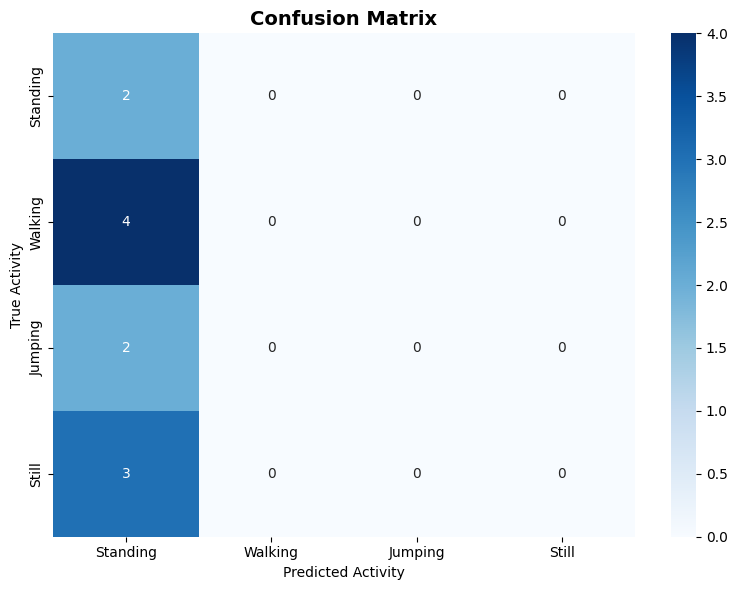

 Confusion matrix saved as 'confusion_matrix.png'


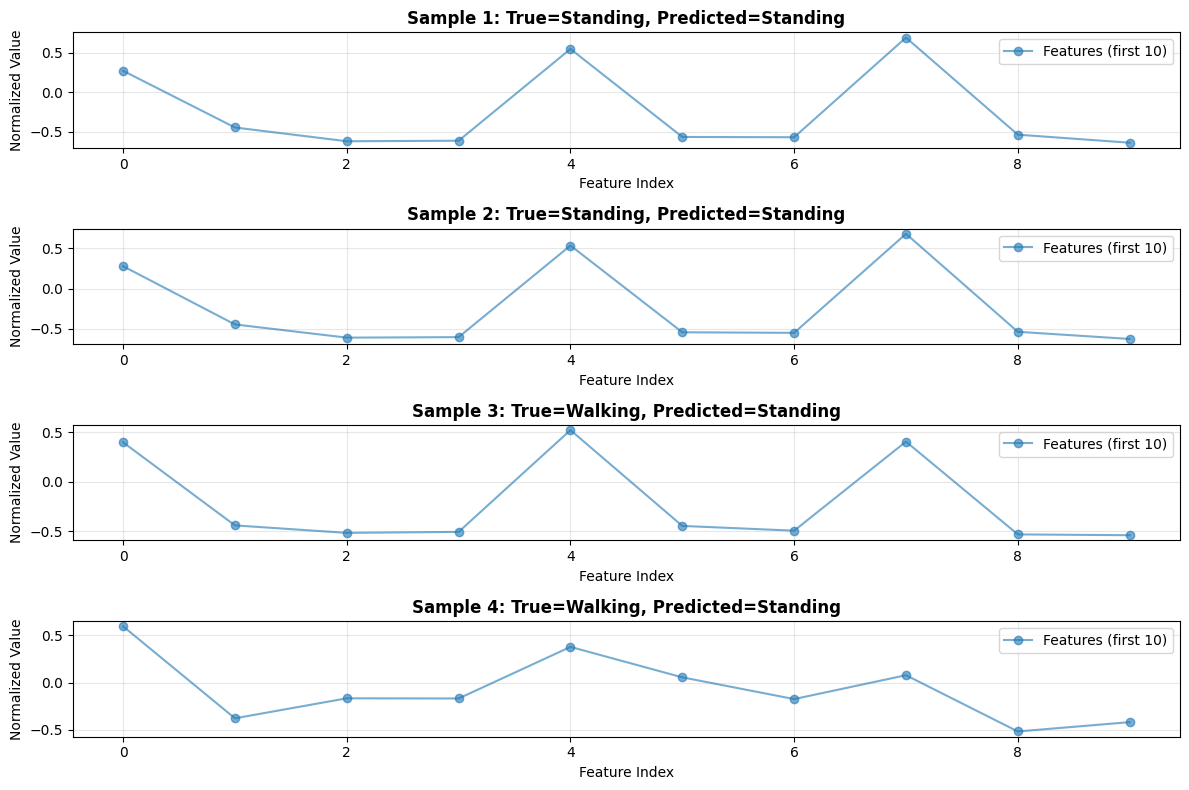

 Prediction examples saved as 'prediction_examples.png'

STEP 7: SAVING RESULTS
Evaluation results saved to 'evaluation_results.csv'
Feature importance saved to 'feature_importance.csv'
Model parameters saved to 'model_parameters.json'

FINAL SUMMARY

Data Collection:
  - Total recordings: 53
  - Activities: Standing, Walking, Jumping, Still

Feature Extraction:
  - Total features: 66
  - Time-domain features: ~30
  - Frequency-domain features: ~18

Model Performance:
  - Overall Accuracy: 0.182
  - Training samples: 42
  - Testing samples: 11

Generated Files:
  - raw_sensor_data_visualization.png
  - transition_matrix.png
  - emission_probabilities.png
  - confusion_matrix.png
  - prediction_examples.png
  - evaluation_results.csv
  - feature_importance.csv
  - model_parameters.json

ANALYSIS COMPLETE! 


In [19]:


# main execution pipeline

def main():
    """Main execution pipeline"""
    
    print("="*60)
    print("HUMAN ACTIVITY RECOGNITION USING HIDDEN MARKOV MODELS")
    print("="*60)
    
    # Step 1: Load data
    print("\n" + "="*30)
    print("STEP 1: DATA LOADING")
    print("="*30)
    
    loader = DataLoader(base_path='samples')
    data = loader.load_all_data()
    
    # Visualize sample data
    loader.visualize_sample_data()
    
    # Step 2: Feature extraction
    print("\n" + "="*30)
    print("STEP 2: FEATURE EXTRACTION")
    print("="*30)
    
    extractor = FeatureExtractor(window_size=50)
    features_df = extractor.process_all_recordings(data, sampling_rate=100)
    
    # Normalize features
    normalized_df = extractor.normalize_features(features_df)
    
    # Display feature summary
    print("\nFeature Summary:")
    print(normalized_df.describe())
    
    # Step 3: Split data into train and test
    print("\n" + "="*30)
    print("STEP 3: TRAIN/TEST SPLIT")
    print("="*30)
    
    # Separate features and labels
    feature_cols = [col for col in normalized_df.columns 
                   if col not in ['activity', 'recording_id']]
    
    X = normalized_df[feature_cols].values
    y = normalized_df['activity'].values
    
    # Split by recording_id to ensure recordings stay together
    unique_recordings = normalized_df['recording_id'].unique()
    np.random.seed(42)
    np.random.shuffle(unique_recordings)
    
    # 80% train, 20% test
    split_idx = int(0.8 * len(unique_recordings))
    train_recordings = unique_recordings[:split_idx]
    test_recordings = unique_recordings[split_idx:]
    
    train_mask = normalized_df['recording_id'].isin(train_recordings)
    test_mask = normalized_df['recording_id'].isin(test_recordings)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"\nTraining distribution:")
    for activity in loader.activities:
        count = np.sum(y_train == activity)
        print(f"  {activity}: {count} samples")
    
    # Step 4: Initialize and train HMM
    print("\n" + "="*30)
    print("STEP 4: HMM TRAINING")
    print("="*30)
    
    # Create HMM
    hmm = HiddenMarkovModel(n_states=4, n_features=X_train.shape[1])
    hmm.initialize_parameters(X_train, y_train, loader.activities)
    
    # Prepare observation sequences for training
    train_sequences = []
    for recording_id in train_recordings:
        mask = normalized_df['recording_id'] == recording_id
        sequence = normalized_df[mask][feature_cols].values
        if len(sequence) > 0:
            train_sequences.append(sequence)
    
    # Train using Baum-Welch
    hmm.baum_welch(train_sequences, max_iterations=50, convergence_threshold=1e-4)
    
    # Step 5: Visualize model parameters
    print("\n" + "="*30)
    print("STEP 5: MODEL VISUALIZATION")
    print("="*30)
    
    hmm.visualize_transition_matrix()
    hmm.visualize_emission_probabilities(feature_cols, top_n=10)
    
    # Step 6: Evaluate model
    print("\n" + "="*30)
    print("STEP 6: MODEL EVALUATION")
    print("="*30)
    
    evaluator = ModelEvaluator(hmm, loader.activities)
    results_df, predictions, overall_acc = evaluator.evaluate(X_test, y_test)
    
    print("\nDetailed Results by Activity:")
    print(results_df.to_string(index=False))
    
    # Plot confusion matrix
    evaluator.plot_confusion_matrix(y_test, predictions)
    
    # Plot prediction examples
    evaluator.plot_predictions(X_test, y_test, predictions, n_samples=4)
    
    # Step 7: Save results
    print("\n" + "="*30)
    print("STEP 7: SAVING RESULTS")
    print("="*30)
    
    # Save evaluation results
    results_df.to_csv('evaluation_results.csv', index=False)
    print("Evaluation results saved to 'evaluation_results.csv'")
    
    # Save feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': np.abs(hmm.emission_means).mean(axis=0)
    }).sort_values('Importance', ascending=False)
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("Feature importance saved to 'feature_importance.csv'")
    
    # Save model parameters
    model_params = {
        'states': hmm.states,
        'initial_prob': hmm.initial_prob.tolist(),
        'transition_prob': hmm.transition_prob.tolist(),
        'emission_means': hmm.emission_means.tolist(),
        'overall_accuracy': float(overall_acc)
    }
    
    import json
    with open('model_parameters.json', 'w') as f:
        json.dump(model_params, f, indent=2)
    print("Model parameters saved to 'model_parameters.json'")
    
    # Summary report
    print("\n" + "="*30)
    print("FINAL SUMMARY")
    print("="*30)
    print(f"\nData Collection:")
    print(f"  - Total recordings: {len(data['Standing']) + len(data['Walking']) + len(data['Jumping']) + len(data['Still'])}")
    print(f"  - Activities: {', '.join(loader.activities)}")
    print(f"\nFeature Extraction:")
    print(f"  - Total features: {len(feature_cols)}")
    print(f"  - Time-domain features: ~{len([f for f in feature_cols if any(x in f for x in ['mean', 'var', 'std', 'rms', 'sma', 'corr'])])}")
    print(f"  - Frequency-domain features: ~{len([f for f in feature_cols if any(x in f for x in ['freq', 'spectral', 'entropy'])])}")
    print(f"\nModel Performance:")
    print(f"  - Overall Accuracy: {overall_acc:.3f}")
    print(f"  - Training samples: {len(X_train)}")
    print(f"  - Testing samples: {len(X_test)}")
    print(f"\nGenerated Files:")
    print("  - raw_sensor_data_visualization.png")
    print("  - transition_matrix.png")
    print("  - emission_probabilities.png")
    print("  - confusion_matrix.png")
    print("  - prediction_examples.png")
    print("  - evaluation_results.csv")
    print("  - feature_importance.csv")
    print("  - model_parameters.json")
    
    print("\n" + "="*30)
    print("ANALYSIS COMPLETE! ")
    print("="*30)
    
    return {
        'hmm': hmm,
        'results': results_df,
        'features_df': normalized_df,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'predictions': predictions
    }

# run main pipeline
if __name__ == "__main__":
    # Execute the full pipeline
    results = main()
  